#  Использование предобученных моделей для классификации изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://pytorch.org/vision/stable/models.html
* https://albumentations.ai/docs/getting_started/image_augmentation/

In [ ]:
import os
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image
from torchvision import models
from torchvision.models import VGG16_Weights
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Задачи для совместного разбора

1\. Загрузите предобученную модель из `torchvision`. Познакомьтесь с ее архитектурой. Заморозьте веса нескольких слоев.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Используя реализацию из `torchvision`, cоздайте модель `vgg16` и загрузите предобученные веса `IMAGENET1K_V1`. Выведите на экран структуру модели, количество слоев и количество настраиваемых (`requires_grad==True`) параметров модели.

- [ ] Проверено на семинаре

In [ ]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 227MB/s] 


In [ ]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
total_layers = sum(1 for _ in vgg16.children())
trainable_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
print(f"Total layers: {total_layers}")
print(f"Trainable parameters: {trainable_params}")

Total layers: 3
Trainable parameters: 138357544


<p class="task" id="2"></p>

2\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

К обучающему датасету примените следующее преобразование: приведите картинки к размеру 256x256, затем обрежьте по центру с размером 224х224, затем переведите изображения в тензор и нормализуйте значения интенсивности пикселей (`mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`).

К тестовому датасету примените преобразование `VGG16_Weights.IMAGENET1K_V1.transforms`.

- [ ] Проверено на семинаре

In [ ]:
data_dir = '/kaggle/input/cat-breeds/cat_breeds_4'

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transform = VGG16_Weights.IMAGENET1K_V1.transforms()

In [ ]:
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

In [ ]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [ ]:
test_dataset.dataset.transform = test_transform

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
print("Dataset and DataLoader prepared:")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Dataset and DataLoader prepared:
Train dataset size: 3200
Test dataset size: 800


<p class="task" id="3"></p>

3\. Заморозьте все веса модели из предыдущего задания. Замените последний слой `Linear` классификатора на новый слой, соответствующий задаче. После изменения последнего слоя выведите на экран количество настраиваемых (`requires_grad==True`) параметров модели. Решите задачу, используя модель с замороженными весами и изменнным последним слоем.

Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [ ]:
for param in vgg16.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 4
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)
trainable_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
print("Trainable parameters after modification:", trainable_params)

Trainable parameters after modification: 16388


In [ ]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

# Обучение модели
num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

start_time = time.time()

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Обучающая фаза
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Тестовая фаза
    vgg16.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

end_time = time.time()
training_time = end_time - start_time

Epoch [1/10], Loss: 0.6725, Train Accuracy: 0.7247, Test Accuracy: 0.7963
Epoch [2/10], Loss: 0.5460, Train Accuracy: 0.7837, Test Accuracy: 0.8075
Epoch [3/10], Loss: 0.5020, Train Accuracy: 0.7963, Test Accuracy: 0.8113
Epoch [4/10], Loss: 0.5016, Train Accuracy: 0.7972, Test Accuracy: 0.8175
Epoch [5/10], Loss: 0.4614, Train Accuracy: 0.8109, Test Accuracy: 0.8075
Epoch [6/10], Loss: 0.4985, Train Accuracy: 0.7937, Test Accuracy: 0.7975
Epoch [7/10], Loss: 0.4800, Train Accuracy: 0.8113, Test Accuracy: 0.8087
Epoch [8/10], Loss: 0.4488, Train Accuracy: 0.8116, Test Accuracy: 0.8000
Epoch [9/10], Loss: 0.4574, Train Accuracy: 0.8209, Test Accuracy: 0.7963
Epoch [10/10], Loss: 0.4497, Train Accuracy: 0.8153, Test Accuracy: 0.7800


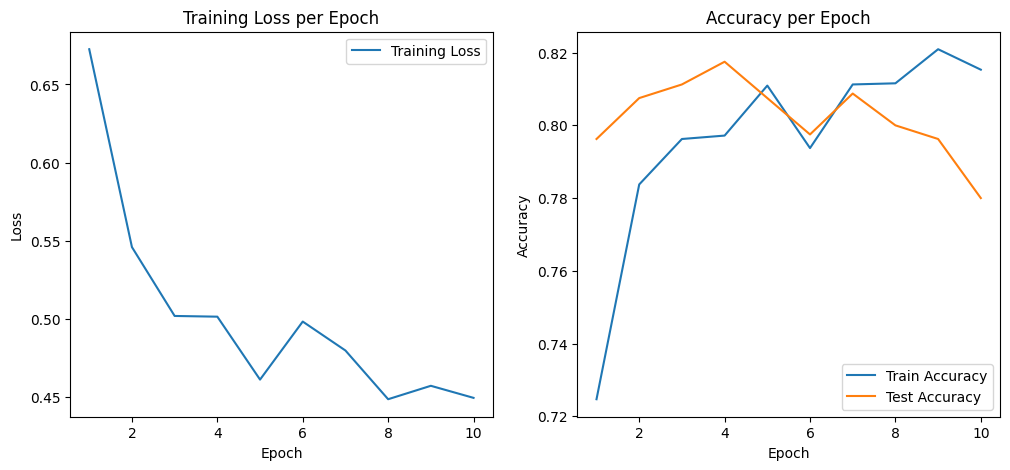

In [ ]:
plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# График accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [ ]:
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

Final Train Accuracy: 0.8153
Final Test Accuracy: 0.7800


<p class="task" id="4"></p>

4\. Повторите решение предыдущей задачи, заморозив все сверточные слои, кроме последнего (слои классификатора не замораживайте). Сравните качество полученного решения и решения из предыдущей задачи, а также время, затраченное на обучения моделей. Перед началом работы создайте модель заново.

- [ ] Проверено на семинаре

In [ ]:
vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

for name, param in vgg16.features.named_parameters():
    if "29" not in name:  # Последний сверточный слой VGG16 находится на индексе 29
        param.requires_grad = False

In [ ]:
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

In [ ]:
trainable_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
print("Trainable parameters with last conv layer unfrozen:", trainable_params)

Trainable parameters with last conv layer unfrozen: 119562244


In [ ]:
vgg16.to(device)

# Определяем функцию потерь и оптимизатор (оптимизатор обновляет классификатор и последний сверточный слой)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg16.parameters()), lr=0.001)

# Обучение модели
num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

start_time = time.time()

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Обучающая фаза
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Тестовая фаза
    vgg16.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

end_time = time.time()
training_time = end_time - start_time

Epoch [1/10], Loss: 1.0673, Train Accuracy: 0.6353, Test Accuracy: 0.7775
Epoch [2/10], Loss: 0.7062, Train Accuracy: 0.7828, Test Accuracy: 0.7700
Epoch [3/10], Loss: 0.5667, Train Accuracy: 0.8428, Test Accuracy: 0.7412
Epoch [4/10], Loss: 0.7126, Train Accuracy: 0.8475, Test Accuracy: 0.7612
Epoch [5/10], Loss: 0.7046, Train Accuracy: 0.8834, Test Accuracy: 0.7937
Epoch [6/10], Loss: 0.6261, Train Accuracy: 0.9009, Test Accuracy: 0.7712
Epoch [7/10], Loss: 0.4449, Train Accuracy: 0.9337, Test Accuracy: 0.7900
Epoch [8/10], Loss: 0.6919, Train Accuracy: 0.9347, Test Accuracy: 0.7512
Epoch [9/10], Loss: 0.9700, Train Accuracy: 0.9178, Test Accuracy: 0.7512
Epoch [10/10], Loss: 1.6096, Train Accuracy: 0.9116, Test Accuracy: 0.7837


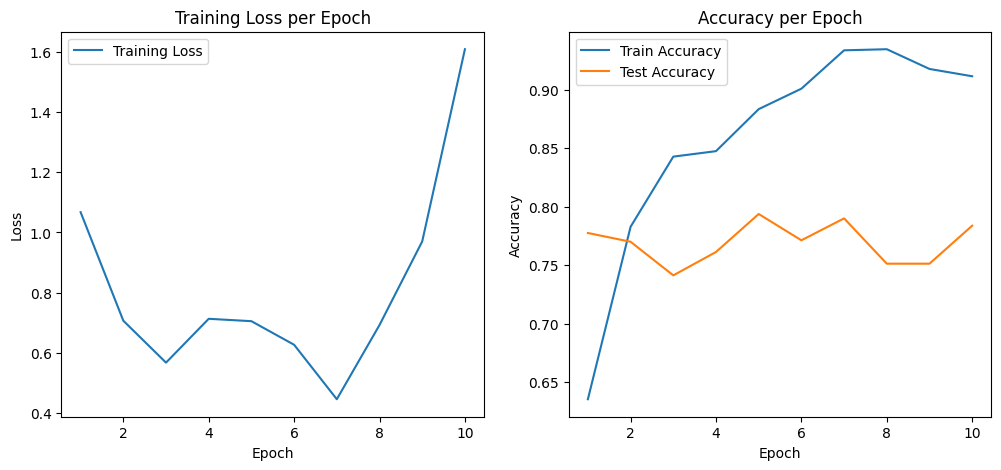

In [ ]:
plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# График accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [ ]:
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")
print(f"Training Time: {training_time:.2f} seconds")

Final Train Accuracy: 0.9116
Final Test Accuracy: 0.7837
Training Time: 339.79 seconds


Выводы

1)Точность на обучающей выборке для модели в 4-й задаче оказалась выше (91.16% против 81.53%). Это связано с тем, что модель с размороженным последним сверточным слоем и классификатором лучше адаптировалась под тренировочные данные.

2)Точность на тестовой выборке в обеих задачах схожа, но модель из 3-й задачи показала более стабильные результаты, что может говорить о лучшей обобщающей способности. Это связано с тем, что в модели 4-й задачи, несмотря на улучшение на обучающей выборке, началось переобучение, из-за чего точность на тестовой выборке не сильно улучшилась.

<p class="task" id="5"></p>

5\. Повторите решение задачи 3, расширив обучающий набор данных при помощи преобразований из `torchvision`, изменяющих изображение (повороты, изменение интенсивности пикселей, обрезание и т.д.). При оценке модели на тестовой выборке данные преобразования применяться не должны. Решение о том, сколько и каких слоев модели будет обучаться, примите самостоятельно. Перед началом работы создайте модель заново.

- [ ] Проверено на семинаре

In [ ]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device)

# Замораживаем все сверточные слои
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, num_classes).to(device)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transform = models.VGG16_Weights.IMAGENET1K_V1.transforms()

In [ ]:
dataset = datasets.ImageFolder(data_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

num_epochs = 10
train_acc_history, test_acc_history = [], []
loss_history = []

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Цикл обучения на обучающем наборе
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Вычисляем метрики после эпохи
    train_accuracy = correct_train / total_train
    train_acc_history.append(train_accuracy)
    loss_history.append(running_loss / total_train)

    # Оценка на тестовом наборе
    vgg16.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    test_acc_history.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / total_train:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch [1/10], Loss: 0.6739, Train Accuracy: 0.7303, Test Accuracy: 0.7863
Epoch [2/10], Loss: 0.5445, Train Accuracy: 0.7784, Test Accuracy: 0.8013
Epoch [3/10], Loss: 0.5161, Train Accuracy: 0.7959, Test Accuracy: 0.8013
Epoch [4/10], Loss: 0.4843, Train Accuracy: 0.8041, Test Accuracy: 0.8037
Epoch [5/10], Loss: 0.4914, Train Accuracy: 0.7987, Test Accuracy: 0.7887
Epoch [6/10], Loss: 0.4588, Train Accuracy: 0.8137, Test Accuracy: 0.8025
Epoch [7/10], Loss: 0.4602, Train Accuracy: 0.8169, Test Accuracy: 0.8013
Epoch [8/10], Loss: 0.4512, Train Accuracy: 0.8137, Test Accuracy: 0.7913
Epoch [9/10], Loss: 0.4611, Train Accuracy: 0.8194, Test Accuracy: 0.7900
Epoch [10/10], Loss: 0.4355, Train Accuracy: 0.8287, Test Accuracy: 0.8075


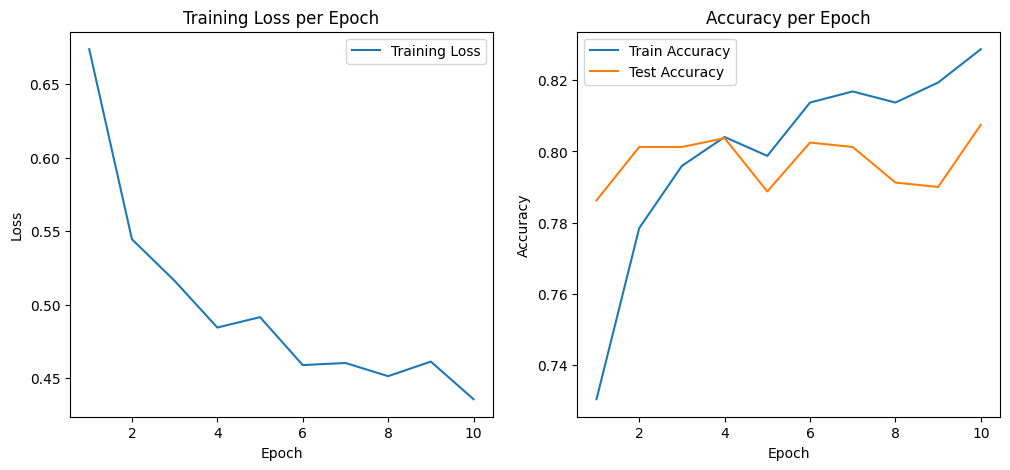

In [ ]:
plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# График accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [ ]:
print(f"Final Train Accuracy: {train_acc_history[-1]:.4f}")
print(f"Final Test Accuracy: {test_acc_history[-1]:.4f}")

Final Train Accuracy: 0.8287
Final Test Accuracy: 0.8075


Модель с применением аугментации и обучением классификатора показала стабильные результаты. На протяжении 10 эпох наблюдался рост точности на обучающем наборе данных, при этом точность на тестовом наборе оставалась относительно постоянной, с небольшими колебаниями.

Выводы:

Точность обучения: Точность на обучающем наборе возросла с 73% до 82.87%, что свидетельствует о хорошем обучении классификатора с использованием аугментаций, которые помогли модели лучше обобщить на новых данных.

Точность на тестовой выборке: На тестовом наборе точность также увеличилась, достигнув 80.75%, что указывает на устойчивость модели к новым данным, хотя и с небольшим отставанием от обучающей выборки.

Снижение функции потерь: Значение функции потерь постепенно уменьшалось, показывая, что модель эффективно минимизировала ошибки классификации.
Аугментации помогли улучшить устойчивость модели и предотвратили сильное переобучение, обеспечив баланс между точностью на обучающем и тестовом наборах.

## Обратная связь
- [ ] Хочу получить обратную связь по решению